In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from align import AlignDlib
from imutils import face_utils
import dlib

from keras.models import load_model,model_from_json
import tensorflow as tf
%matplotlib inline


Using TensorFlow backend.


(1280, 958, 3)


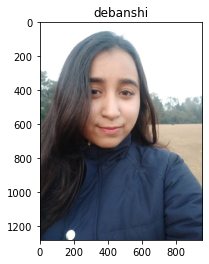

In [2]:
import os
import re
path= "./images"
mylist=os.listdir(path)
my_images=[]
myclass=[]

for cl in mylist:
    if re.search(r'.*jpg$',str(cl)) !=None:
        img=cv2.imread(os.path.join(path,cl))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        my_images.append(img)
        myclass.append(os.path.splitext(cl)[0])

        
        
print(my_images[0].shape)
plt.title(myclass[0])
plt.imshow(my_images[0])

In [3]:
def load_final_model():
    '''
    Loads the Final Model saved in the fir 'final_model'
    '''
    # load json and create model
    json_file = open('final_model/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    nn4_small2 = model_from_json(loaded_model_json,custom_objects={'tf': tf})
    # load weights into new model
    nn4_small2.load_weights("final_model/model.h5")
    print("[INFO]:Loaded model from disk")
    return nn4_small2

In [4]:
model = load_final_model()
print(model.summary())

[INFO]:Loaded model from disk
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________________________

In [5]:
def align_image(img,bb):
    '''
    OBJECTIVE: Align a face based using DLIB model
    
    Parameter:
    test - RGB Image
    bb - bounding box around the person to be searched
    
    Returns:
    Aligned face
    
    '''
    
    # return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
    if(bb):
        return alignment.align(96, img, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
    else:
        return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [6]:

def generate_encoding(img,bb):
    '''
    OBJECTIVE: Generates an 128D encoding based on the loaded model
    
    Parameter:
    test - RGB Image
    bb - bounding box around the person to be searched
    
    Returns:
    embedded-128D encoding
    '''
    embedded = np.zeros((1, 128)) #Declare a placeholder variable
    #print(m.image_path())    
    # img = load_image(path)
    img = align_image(img,bb) #Align the image 
    # plt.imshow(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded= nn4_small2.predict(np.expand_dims(img, axis=0))[0] #generate encoding
    return embedded

In [7]:
def distance(emb1, emb2):
    '''
    OBJECTIVE: Compute and return eucledian distance
    '''
    return np.sum(np.square(emb1 - emb2))

In [8]:
def recognise(test,bb):
    '''
    OBJECTIVE: Search the database for matching faces based on lowest distance
    
    Parameter:
    test - RGB Image
    bb - bounding box around the person to be searched
    
    Returns:
    min_dist - Minimum distance on the 128D space 
    identity - str identity of person matched as stored in database, 0 if no person found
    '''
    
    threshold = 0.75 #Set according to the Facenet Paper
    test_em=None
    test_em = generate_encoding(test,bb) #Generate the 128D encoding
    min_dist = 100 #Set a max min distance

    for (name, db_enc) in database.items(): #Checks for each entries in the database

        dist = distance(test_em,db_enc)

        if dist < min_dist:
          min_dist = dist
          identity = name


    if min_dist > threshold:
        identity=0
    #       print(min_dist,"Not in the database.")
    else:
    #       print (min_dist,"it's " + str(identity) )
        pass


    return min_dist, identity

In [9]:
def make_database(entries):
    '''
    OBJECTIVE: Generate Database
    
    Parameters:python dictionary with the keys as id and values and image path 
    '''
    database={}
    print('[INFO]:Creating New Database....')    
    for (i,j) in entries.items():
        if i not in database.keys():
            img = entries[i]
            #       print(i)
            database[i] = generate_encoding(img,0)
    return database

    print('[INFO]:New Database Creation Completed!')

entries={myclass[i]:my_images[i] for i in range(len(myclass))}
database=make_database(entries)
#database={}
detector = dlib.get_frontal_face_detector()
    # Initialize the OpenFace face alignment utility
alignment = AlignDlib('shape_predictor_68_face_landmarks.dat')
nn4_small2 = load_final_model()
for (i,j) in entries.items():
        if i not in database.keys():
            img = entries[i]
            #       print(i)
            database[i] = generate_encoding(img,0)
print(type(database["shaima1"]))

In [18]:
def live_feed():
    
    '''
    OBJECTIVE: Perform Face Recognition on Live Video    
    '''
    cap = cv2.VideoCapture(0)
    
    while True:
            start_frame_number = 5
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_number)
            ret, img = cap.read()
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            subjects = detector(rgbImg, 1)

            for subject in subjects:
                (x, y, w, h) = face_utils.rect_to_bb(subject)
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
                dist , id = recognise(rgbImg,subject)
                if(id!=0):
                    cv2.rectangle(img, (x, y-20), (x + w, y + 20), (0, 255, 0), cv2.FILLED)
                    cv2.putText(img, "Face : " + str(id), (x+6,y-6),cv2.FONT_HERSHEY_COMPLEX,.5,(255,255,255),1)
                else:
                    cv2.putText(img, "Face : " + 'Not Recognised', (x+6, y - 6), cv2.FONT_HERSHEY_COMPLEX, .5, (0, 255, 100), )
            cv2.imshow('Recognizing faces', img)
            if cv2.waitKey(1) == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

In [26]:
from datas1 import Generate_Database
if __name__ == '__main__':
    '''
    Main function
    '''
    detector = dlib.get_frontal_face_detector()
    # Initialize the OpenFace face alignment utility
    alignment = AlignDlib('shape_predictor_68_face_landmarks.dat')
    nn4_small2 = load_final_model()    
    entries={myclass[i]:my_images[i] for i in range(len(myclass))}
    db=Generate_Database(nn4_small2,alignment)
    db.make_database(entries)
    
    
    

    

[INFO]:Loaded model from disk
[INFO]:Creating New Database....


NameError: name 'np' is not defined

In [20]:
live_feed()

KeyboardInterrupt: 

In [34]:
    alignment = AlignDlib('shape_predictor_68_face_landmarks.dat')
    

In [30]:
nn4_small2 = load_final_model()    
    

[INFO]:Loaded model from disk


In [35]:
   
    entries={myclass[i]:my_images[i] for i in range(len(myclass))}
    

In [36]:
db=Generate_Database(nn4_small2,alignment)
    

In [38]:

    database=db.make_database(entries)

[INFO]:Creating New Database....


NameError: name 'np' is not defined